In [1]:
import os
from PIL import Image, ImageDraw

import elasticdeform, imageio
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['figure.figsize'] = [10, 10]

import warnings
warnings.filterwarnings('ignore')

In [2]:
### ----- Image decoding ----
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

### ----- Cleaning data -------
def remove_white_area(image):
    '''
      output is (2560, 2560, 3) for images and (2560, 2560) for labels
    '''
    size = 2560
    ### images
    if len(image.shape) == 3:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1, :]
        return image[x:y, x:y, :]
      
      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2
      
      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1), (0, 0)), constant_values=(245, 245))
      return np.pad(image, ((x, x), (y, y), (0, 0)), constant_values=(245, 245))
      
    ### labels
    if len(image.shape) == 2:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1]
        return image[x:y, x:y]

      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2

      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1)), constant_values=(0, 0))
      return np.pad(image, ((x, x), (y, y)), constant_values=(0, 0))
    

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
# Old Dataset
class KaggleDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_dir)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Labels
        labels = self.labels.iloc[index]
        id = str(labels['id'])
        # Image
        img_path = os.path.join(self.image_dir, id + ".tiff")
        image = np.array(Image.open(img_path).convert("RGB"))
        # rle
        rle = labels['rle']
        decoded_rle = rle_decode(rle, shape = image.shape[:2])

        # return remove_white_area(image), remove_white_area(decoded_rle)
        # TODO: To use Dataset with jpeg ----> No transpose!!
        return image, decoded_rle.T

In [4]:
IMAGES_DIRECTORY = "data/train_images/"
ANNOTATION_DIRECTORY = "data/train_annotations/"
TRAIN_LABEL_DIRECTORY = "data/train.csv"

dataset = KaggleDataset(
    image_dir=IMAGES_DIRECTORY,
    label_dir=TRAIN_LABEL_DIRECTORY,
)

In [9]:
# img, label = dataset[40]
# def_img, def_lab = elasticdeform.deform_random_grid([img, label], sigma=200, points=3, axis=[(0,1), (0,1)], rotate=0)
# def_img = np.where(def_img==0, 245, def_img)
# print(f'{def_img.shape=}')
# print(f'{def_lab.shape=}')

# fig, ax = plt.subplots(1,2)
# ax = ax.flatten()
# im = ax[0].imshow(img)
# cm = im.get_cmap()
# cm.set_under('k', alpha=0)
# ax[0].imshow(label, cmap=cm,
#           interpolation='none', 
#           clim=[0.9, 1], alpha = 0.4)

# im = ax[1].imshow(def_img)
# cm = im.get_cmap()
# cm.set_under('k', alpha=0)
# ax[1].imshow(def_lab, cmap=cm,
#           interpolation='none', 
#           clim=[0.9, 1], alpha = 0.4)
# # ax[2].imshow(def_lab)j

In [6]:
# Changed it so now it rotates 2 times
rotation_angles = [35, 70, 98, 160, 240]
df = pd.DataFrame(columns=['id', 'rle'])
j = 0
sigma = 15
for i, (img, label) in enumerate(dataset):

  def_img, def_lab = elasticdeform.deform_random_grid([img, label], sigma=sigma, points=3, axis=[(0,1), (0,1)], 
                                                                         rotate=random.choice(rotation_angles)) 
  def_img = np.where(def_img==0, 245, def_img)


  def_img_rot, def_lab_rot = elasticdeform.deform_random_grid([img, label], sigma=sigma, points=3, axis=[(0,1), (0,1)]
                                                                          , rotate=random.choice(rotation_angles))
  def_img_rot = np.where(def_img_rot==0, 245, def_img_rot)

  # Save original img and label as jpeg
  imageio.imsave(f'augmented_data/{j}.jpeg', img)
  encoded_label = rle_encode(label)
  item = {'id':j, 'rle': encoded_label}
  df = df.append(item, ignore_index=True)
  j += 1

  # Save deformed img and label as jpeg
  imageio.imsave(f'augmented_data/{j}.jpeg', def_img)
  encoded_label = rle_encode(def_lab)
  item = {'id':j, 'rle': encoded_label}
  df = df.append(item, ignore_index=True)
  j += 1

  # Save deformed and rotated img and label as jpeg
  imageio.imsave(f'augmented_data/{j}.jpeg', def_img_rot)
  encoded_label = rle_encode(def_lab_rot)
  item = {'id':j, 'rle': encoded_label}
  df = df.append(item, ignore_index=True)
  j += 1

df.to_csv('augmented_labels.csv', index=False)

In [261]:
# New Dataset
class KaggleDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_dir)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Labels
        labels = self.labels.iloc[index]
        id = str(labels['id'])
        # Image
        img_path = os.path.join(self.image_dir, id + ".jpeg")
        image = np.array(Image.open(img_path).convert("RGB"))
        # rle
        rle = labels['rle']
        decoded_rle = rle_decode(rle, shape = image.shape[:2])

        # return remove_white_area(image), remove_white_area(decoded_rle)
        # TODO: To use Dataset with jpeg ----> No transpose!!
        return image, decoded_rle

IMAGES_DIRECTORY = "augmented_data/"
TRAIN_LABEL_DIRECTORY = "augmented_labels.csv"

dataset = KaggleDataset(
    image_dir=IMAGES_DIRECTORY,
    label_dir=TRAIN_LABEL_DIRECTORY,
)

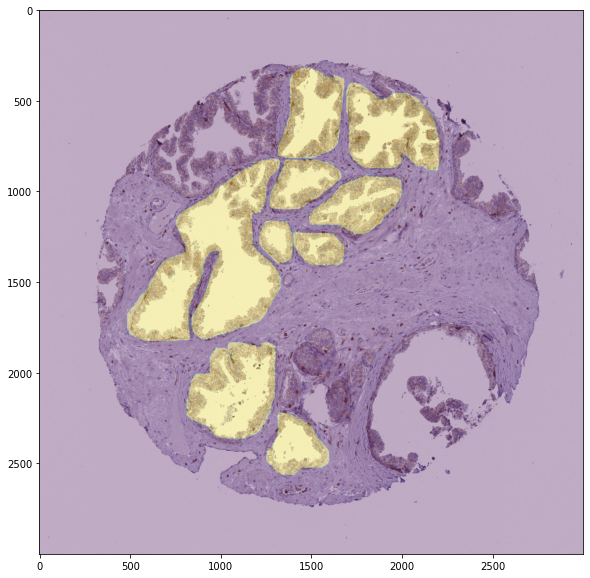

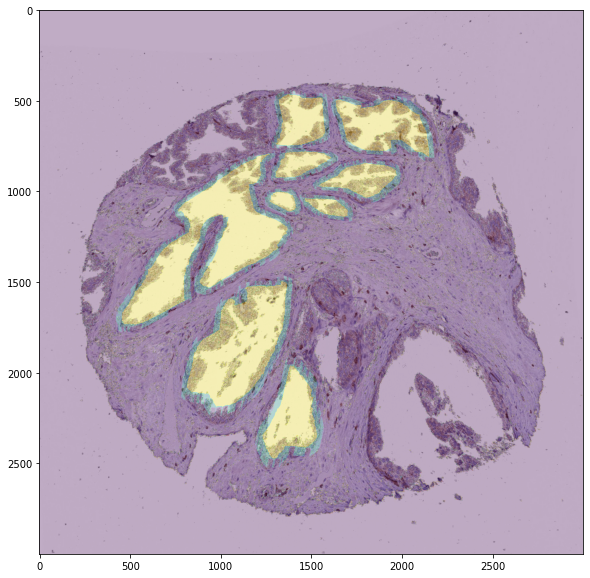

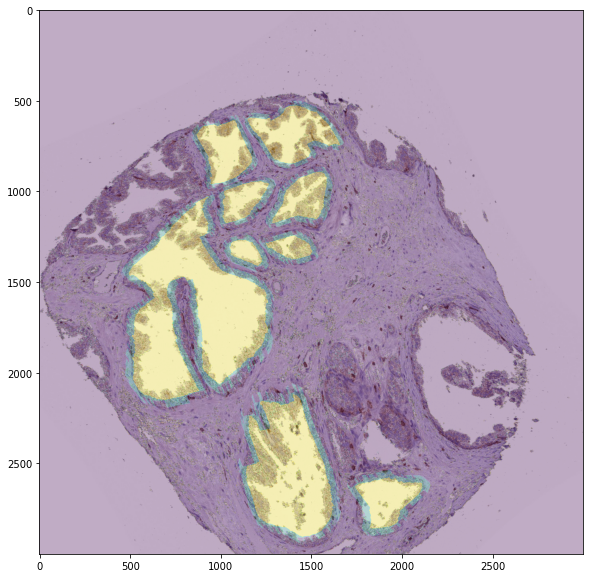

In [262]:
# img, label = dataset[2]
# fig, ax = plt.subplots(1)
# ax.imshow(img)
# ax.imshow(label, alpha=0.2)
for (img, label) in dataset:
  plt.close()
  plt.imshow(img)
  plt.imshow(label, alpha=0.3)
  plt.show()